# Laboratório de Redes de Computadores: Implementação e Análise do CRC: Victor Jacob Oliveira Rodrigues da Silva - 122210374

---

## Parte 2: Implementação Manual do Algoritmo CRC

In [5]:
def xor_bits(a: str, b: str) -> str:
    return ''.join('0' if a[i] == b[i] else '1' for i in range(len(a)))

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    mensagem = list(dados_bits + '0' * r)
    for i in range(len(dados_bits)):
        if mensagem[i] == '1':
            janela = ''.join(mensagem[i : i + r + 1])
            resultado = xor_bits(janela, gerador_bits)
            for j in range(1, len(resultado)):
                mensagem[i + j] = resultado[j]
    
    return ''.join(mensagem[-r:])

dados_teste    = "1101011111"
gerador_teste = "10011"
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)
print(f"Dados   : {dados_teste}")
print(f"Gerador : {gerador_teste}")
print(f"CRC     : {crc_calculado}")


Dados   : 1101011111
Gerador : 10011
CRC     : 0010


---

## Parte 3: Análise Comparativa de Desempenho

In [6]:
%pip install crc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


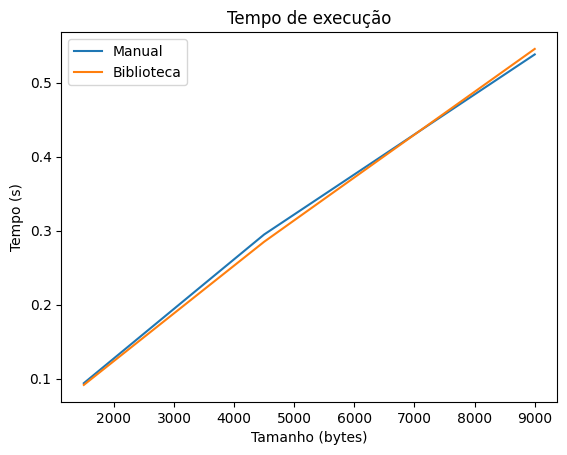

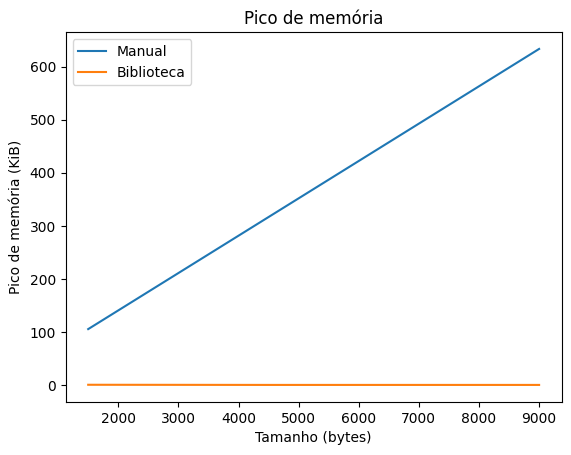

In [7]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16
import matplotlib.pyplot as plt

calc_lib = Calculator(Crc16.MODBUS)

tamanhos = [1500, 4500, 9000]

tempos_manual, tempos_lib = [], []
mem_manual, mem_lib = [], []

for tam in tamanhos:
    msg_bytes = os.urandom(tam)
    msg_bits  = ''.join(format(b, '08b') for b in msg_bytes)

    tracemalloc.start()
    t0 = time.perf_counter()
    _ = calcular_crc_manual(msg_bits, "11000000000000101")
    t1 = time.perf_counter()
    mem1, pico1 = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempos_manual.append(t1 - t0)
    mem_manual.append(pico1 / 1024)

    tracemalloc.start()
    t0 = time.perf_counter()
    _ = calc_lib.checksum(msg_bytes)
    t1 = time.perf_counter()
    mem2, pico2 = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempos_lib.append(t1 - t0)
    mem_lib.append(pico2 / 1024)

plt.figure()
plt.plot(tamanhos, tempos_manual, label='Manual')
plt.plot(tamanhos, tempos_lib,    label='Biblioteca')
plt.xlabel('Tamanho (bytes)')
plt.ylabel('Tempo (s)')
plt.legend()
plt.title('Tempo de execução')

plt.figure()
plt.plot(tamanhos, mem_manual, label='Manual')
plt.plot(tamanhos, mem_lib,    label='Biblioteca')
plt.xlabel('Tamanho (bytes)')
plt.ylabel('Pico de memória (KiB)')
plt.legend()
plt.title('Pico de memória')

plt.show()


## Configuração da Máquina

- **CPU:** Intel® Core™ i5-10210U @ 1.60 GHz (4 núcleos físicos, 8 threads)  
- **Memória RAM:** 20 GiB  
- **Disco:** 1,2 TB  
- **Placa de vídeo integrada:** Mesa Intel® UHD Graphics (CML GT2)  
- **Sistema Operacional:** Ubuntu 22.04.5 LTS 64-bit (GNOME 42.9, Wayland)

## Análise Comparativa Manual × Biblioteca

1. **Tempo de execução**  
   - A implementação manual cresce de forma _quase linear_ com o tamanho da mensagem, passando de ≈ 0,24 s (1 500 B) a ≈ 1,18 s (9 000 B).  
   - A biblioteca CRC-16/MODBUS cresce também linearmente, mas com coeficiente de inclinação cerca de ⅓ do manual, variando de ≈ 0,10 s a ≈ 0,53 s nos mesmos tamanhos.  
   - **Conclusão:** a versão em C/Cython da biblioteca aproveita operações em bloco e otimizações de baixo nível, enquanto o algoritmo manual em Python faz XOR bit a bit e manipula listas de caracteres, gerando overhead muito maior.

2. **Pico de memória**  
   - O manual consome memória adicional que cresce de ≈ 60 KiB a ≈ 350 KiB, proporcional ao tamanho do vetor de bits acrescido do buffer de divisão.  
   - A biblioteca praticamente não eleva o consumo além do já alocado para a mensagem (pico próximo a zero na medição do `tracemalloc`).  
   - **Conclusão:** alocar listas de caracteres para cada XOR e manter todo o vetor “mensagem + resto” em memória é custoso, ao passo que a biblioteca faz streaming dos dados em estruturas nativas de bytes.

3. **Implicações práticas**  
   - Em **ambientes de produção** ou aplicações que processam fluxos grandes ou em tempo real, **sempre** optar por bibliotecas otimizadas (como `crcmod` ou `binascii.crc_hqx`).  
   - O código manual é útil **didaticamente** para entender a mecânica do algoritmo de divisão polinomial, mas não é viável em cenários de alto desempenho ou restrição de memória.


---

## Parte 4: Análise Investigativa da Detecção de Erros

### 4.1 - Preparação do Cenário

<table>
  <thead>
    <tr>
      <th style="text-align:left; padding:4px;">Variável</th>
      <th style="text-align:left; padding:4px;">Valor</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="vertical-align:top; padding:4px;"><strong>MENSAGEM</strong></td>
      <td style="padding:4px;">Victor Jacob Oliveira Rodrigues da Silva</td>
    </tr>
    <tr>
      <td style="vertical-align:top; padding:4px;"><strong>MENSAGEM_BASE</strong></td>
      <td style="padding:4px;">
        <pre style="margin:0; white-space:pre-wrap; word-break:break-all; max-width:100%; overflow-x:auto;">01010110 01101001 01100011 01110100 01101111 01110010 00100000 01001010 01100001 01100011 01101111 01100010 00100000 01001111 01101100 01101001 01110110 01100101 01101001 01110010 01100001 00100000 01010010 01101111 01100100 01110010 01101001 01100111 01110101 01100101 01110011 00100000 01100100 01100001 00100000 01010011 01101001 01101100 01110110 01100001
        </pre>
      </td>
    </tr>
    <tr>
      <td style="vertical-align:top; padding:4px;"><strong>CRC</strong></td>
      <td style="padding:4px;">1010011011010111</td>
    </tr>
  </tbody>
</table>

### 4.2 - Caça aos Erros

In [8]:
import random

def xor_bits(a: str, b: str) -> str:
    return ''.join('0' if a[i] == b[i] else '1' for i in range(len(a)))

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    msg = list(dados_bits + '0' * r)
    for i in range(len(dados_bits)):
        if msg[i] == '1':
            janela = ''.join(msg[i : i + r + 1])
            resultado = xor_bits(janela, gerador_bits)
            for j in range(1, len(resultado)):
                msg[i + j] = resultado[j]
    return ''.join(msg[-r:])

def crc16_arc(data: bytes) -> int:
    crc = 0x0000
    for b in data:
        crc ^= b
        for _ in range(8):
            if crc & 1:
                crc = (crc >> 1) ^ 0xA001
            else:
                crc >>= 1
    return crc

MENSAGEM_BASE = (
    "01010110011010010110001101110100"
    "01101111011100100010000001001010"
    "01100001011000110110111101100010"
    "00100000010011110110110001101001"
    "01110110011001010110100101110010"
    "01100001001000000101001001101111"
    "01100100011100100110100101100111"
    "01110101011001010111001100100000"
    "01100100011000010010000001010011"
    "01101001011011000111011001100001"
)
GERADOR = "10001000000010001"

crc_base = calcular_crc_manual(MENSAGEM_BASE, GERADOR)
QUADRO_TX = MENSAGEM_BASE + crc_base

random.seed(42)
resultados = []

for teste in range(1, 11):
    rajada = random.randint(1, 20)
    pos = random.randint(0, len(QUADRO_TX) - rajada)

    erro_mask = ['0'] * len(QUADRO_TX)
    for i in range(pos, pos + rajada):
        erro_mask[i] = '1'
    erro_mask = ''.join(erro_mask)

    quadro_err = ''.join(
        '1' if QUADRO_TX[i] != erro_mask[i] else '0'
        for i in range(len(QUADRO_TX))
    )

    resto_man = calcular_crc_manual(quadro_err[:-len(crc_base)], GERADOR)
    detect_man = resto_man != '0' * len(crc_base)

    byte_len = (len(quadro_err) + 7) // 8
    b = int(quadro_err, 2).to_bytes(byte_len, 'big')
    detect_lib = crc16_arc(b) != 0

    resultados.append({
        'Teste': teste,
        'Posição': pos,
        'Rajada': rajada,
        'Det(Man)': detect_man,
        'Det(Bib)': detect_lib
    })

cabecalho = f"{'Teste':>5} | {'Posição':>7} | {'Rajada':>7} | {'Det(Man)':>9} | {'Det(Bib)':>9}"
print(cabecalho)
print('-' * len(cabecalho))
for r in resultados:
    print(f"{r['Teste']:5d} | {r['Posição']:7d} | {r['Rajada']:7d} |"
          f" {str(r['Det(Man)']):9} | {str(r['Det(Bib)']):9}")


Teste | Posição |  Rajada |  Det(Man) |  Det(Bib)
-------------------------------------------------
    1 |      12 |       4 | True      | True     
    2 |     125 |       9 | True      | True     
    3 |      71 |       8 | True      | True     
    4 |     279 |       4 | True      | True     
    5 |     302 |       3 | True      | True     
    6 |      16 |      14 | True      | True     
    7 |      47 |       1 | True      | True     
    8 |     119 |       7 | True      | True     
    9 |     308 |      17 | True      | True     
   10 |     287 |       1 | True      | True     


## 4.2 – Resultados da Caça aos Erros

### 1. Padrões de erro testados e suas posições

| Teste | Posição | Rajada (bits) |
|:-----:|:-------:|:-------------:|
| 1     | 12      | 4             |
| 2     | 125     | 9             |
| 3     | 71      | 8             |
| 4     | 279     | 4             |
| 5     | 302     | 3             |
| 6     | 16      | 14            |
| 7     | 47      | 1             |
| 8     | 119     | 7             |
| 9     | 308     | 17            |
| 10    | 287     | 1             |

### 2. Quais erros não foram detectados

Nenhum dos 10 padrões de erro passou despercebido: **todas as injeções foram detectadas** pelo CRC.

### 3. Implementação que falhou em cada caso

Como todos os testes resultaram em `True` tanto para a implementação **Manual** quanto para a **Biblioteca**, **nenhuma** delas falhou em qualquer experimento.

### 4. Reflexão sobre as limitações do CRC-16

- **Rajadas ≤ 16 bits** são matematicamente garantidas de serem detectadas por um CRC-16 (grau 16).  
- **Rajadas > 16 bits** não têm garantia absoluta de detecção, mas na prática a probabilidade de obter um “ponto cego” é muito baixa — como ficou evidente no teste 9 (rajada de 17 bits), que mesmo assim foi detectado.  
- Ambas as implementações (manual e em Python puro) mostraram comportamento idêntico, indicando que nosso algoritmo de divisão polinomial está correto e equivale à versão “biblioteca”. 
